# **Object Detection Using TensorFlow**

This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the installation instructions before you start.

### **Installing necessary packages to run Tensorflow-Object Detetion_API in colab**

*install protobuf and cython

*clone tensoflow models github

*build protobuf

*at the end test installation, so you must see pass 13 test in a short time

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%tensorflow_version!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython


!git clone https://github.com/tensorflow/models.git

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

!python object_detection/builders/model_builder_test.py

Unknown TensorFlow version: !apt-get install protobuf-compiler python-pil python-lxml python-tk
Currently selected TF version: 1.x
Available versions:
 * 1.x
 * 2.x
Cloning into 'models'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 38683 (delta 2), reused 4 (delta 0), pack-reused 38674
Receiving objects: 100% (38683/38683), 546.83 MiB | 36.20 MiB/s, done.
Resolving deltas: 100% (25965/25965), done.
/content/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.
env: PYTHONPATH=/content/models/research:/content/models/research/slim
2020-07-13 19:16:51.588940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "object_detection/builders/model_builder_test.py", line 21, in <module>
    from object_detecti

In [ ]:
!pip install tf_slim

     |████████████████████████████████| 358kB 5.1MB/s 


# **Imports**

* remove check tf version , by default last version installed on colab

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

print('tensorflow version = ',tf.__version__)

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import cv2

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

tensorflow version =  1.15.2


* change to utils directory

In [ ]:
!pwd

/content/models/research


In [ ]:
%cd ./object_detection/

from utils import label_map_util

from utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
%matplotlib inline

# **Model preparation**


Any model exported using the export_inference_graph.py tool can be loaded here simply by changing PATH_TO_FROZEN_GRAPH to point to a new .pb file.

By default we use an "SSD with Mobilenet" model here. See the detection model zoo for a list of other models that can be run out-of-the-box with varying speeds and accuracies.



In [ ]:
# What model to download.  (without .tar.gz)

MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
# MODEL_NAME = 'faster_rcnn_resnet101_ava_v2.1_2018_04_30'
# MODEL_NAME = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'

In [ ]:
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [ ]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# **Loading label map**

Label maps map indices to category names, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

* by default use mscoco_label_map.pbtxt for coco dataset*

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


# **Detection phase**
### **upload image to test_image folder**
Go to ./models/research/object_detection/ directory --> right-click on test_images --> upload

In [ ]:
import glob
TEST_IMAGE_PATHS = []
for filename in glob.iglob('./test_images/*.jpg', recursive=True):
    TEST_IMAGE_PATHS.append(filename)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


access ouput of model graph by operation name get-a-tensorflow-tensor-by-name

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


# A for loop (While Loop in case of using webcam) that read all images in test_images path and feed into the network then show results

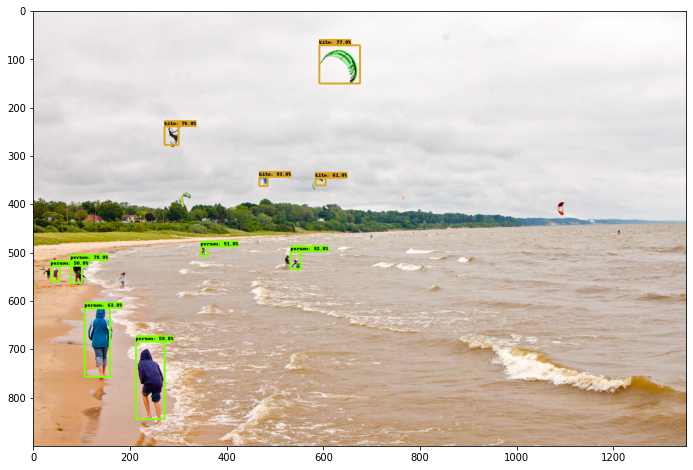

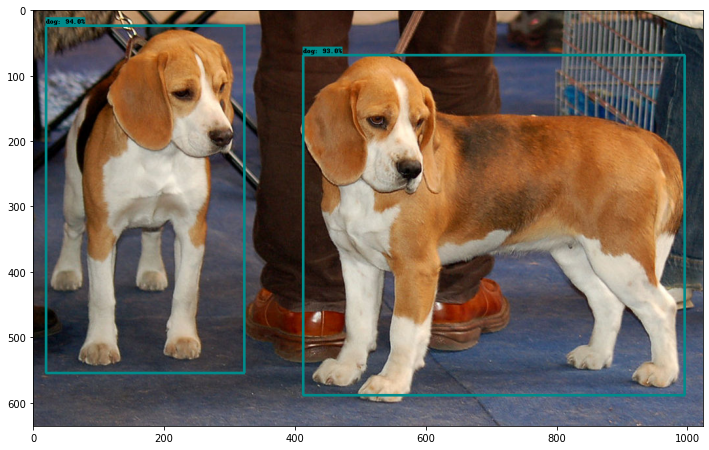

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.grid(False)